In [64]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
from scipy.stats import sem

from fcutils.maths.signals import get_onset_offset
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths import rolling_mean

sys.path.append("./")

fld = Path(os.getcwd()).parent
sys.path.append(str(fld))


from electrophysiology.utils import load_rec_data, get_locomotion_onset_times

# cache = Path(r"/Volumes/EGZONA/Egzona/Forceplate/neuropixels")
cache = Path("/Volumes/EGZONA/Egzona/Forceplate/neuropixels")
tracking_files = cache.glob("*.parquet")
recordings = [f.stem for f in tracking_files]
len(recordings)



36

## Get for each recordings all the time the mouse goes from stationary to moving

In [65]:
tracking, units = load_rec_data(cache, recordings[10])
print(len(units.columns))

7


In [100]:
units

,PRNc,POST,VISp6a,PRNr,PPN,CUN,ICe
0,27.232812,59.779435,30.729952,15.778971,0.134682,143.121061,13.490986
1,27.237747,59.765409,30.719285,15.775062,0.135205,143.124733,13.488077
2,27.247608,59.737371,30.697964,15.767252,0.136253,143.132071,13.487393
3,27.262383,59.695348,30.666017,15.758232,0.137828,143.143060,13.486264
4,27.282047,59.639380,30.623484,15.742895,0.139933,143.157683,13.484699
...,...,...,...,...,...,...,...
3064379,0.000000,3.649893,0.000000,16.160697,0.000000,27.403626,32.333560
3064380,0.000000,3.627959,0.000000,16.131620,0.000000,27.401349,32.349546
3064381,0.000000,3.611509,0.000000,16.109797,0.000000,27.399642,32.361530
3064382,0.000000,3.600543,0.000000,16.095241,0.000000,27.398504,32.369517


In [91]:
from fcutils.maths import derivative


def find_starting_paw(tracking:pd.DataFrame, start:int) -> str:
    paw_values = dict(
        left_fl_v = tracking.left_fl_v[start],
        # left_hl_v = tracking.left_hl_v[start],
        right_fl_v = tracking.right_fl_v[start],
        # right_hl_v = tracking.right_hl_v[start]
    )
    starter = list(paw_values.keys())[np.argmax(list(paw_values.values()))]
    return starter

def get_locomotion_onset_times(
            tracking: pd.DataFrame, 
            paw:str="right_fl", 
            cutoff=2000,
            movement_th = 9,
    ) -> list:
    """
        Finds the precise timing of locomotion onsets from tracking data, looking
        specifically for the movement of the selected paw.
    """

    # get when each of the paw is movign
    def is_it_moving(v):
        is_moving = np.where(v > movement_th)[0]
        moving = np.zeros_like(v)
        moving[is_moving] = 1
        return moving

    left_fl = is_it_moving(tracking.left_fl_v)
    right_fl = is_it_moving(tracking.right_fl_v)
    # left_hl = is_it_moving(tracking.left_hl_v)
    # right_hl = is_it_moving(tracking.right_hl_v)

    paws_speed = np.vstack([tracking.left_fl_v, tracking.right_fl_v])

    # check how many paws are moving
    moving = np.sum([left_fl, right_fl], axis=0)
    moving[moving <  1] = 0
    moving[moving >= 1] = 1

    # get start/stop of movement
    move_start, _ = get_onset_offset(moving, .5)
    print(f"Found {len(move_start)} movement candidates")
    v = tracking.v.values
    d = derivative(tracking.left_fl_v) if "left" in paw else derivative(tracking.right_fl_v)


    selected = 0
    timepoints = []
    for start in move_start:
        if start < 5000 or start > len(v)-5000:
            continue
        if start < cutoff:
            continue
        
        # exclude baddies
        if np.any(paws_speed[:, start-cutoff:start] > 10):
            continue
        
        if np.min(v[start+200:start+500]) < 2.5:
            continue

        if len(timepoints) and start - timepoints[-1] < cutoff:
            continue

        # find precise start time based on derivative
        _d = d[start-500:start]
        try:
            shift = np.where(_d < 0)[0][-1]
        except IndexError:
            shift = 500
        precise_start = start - (500 - shift)

        # make sure it's the right paw
        starter = find_starting_paw(tracking, precise_start)
        if paw not in starter:
            continue
        selected += 1

        timepoints.append(precise_start)

    return timepoints

In [92]:
right_fl_onsets = get_locomotion_onset_times(tracking, "right_fl", cutoff=2000)
left_fl_onsets = get_locomotion_onset_times(tracking, "left_fl", cutoff=2000)

print(f"Number of onsets: {len(right_fl_onsets)} right - {len(left_fl_onsets)} left")

Found 1847 movement candidates
Found 1847 movement candidates
Number of onsets: 19 right - 9 left


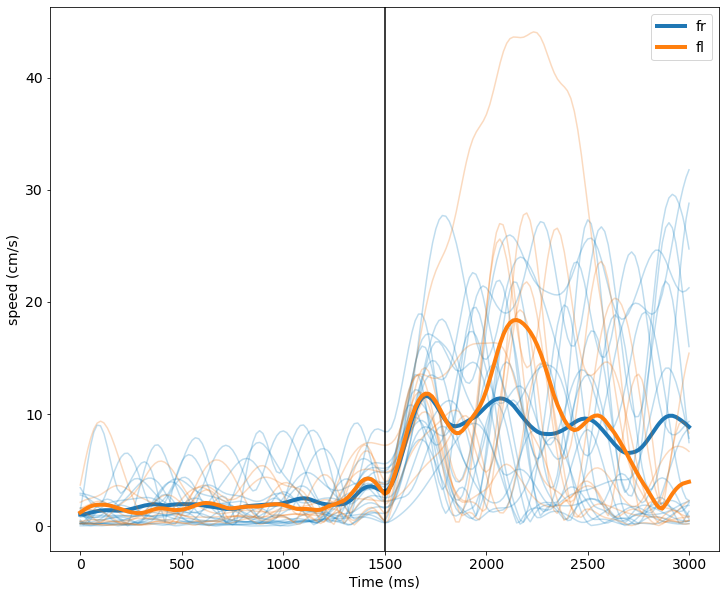

In [97]:
# set font size
plt.rcParams.update({"font.size": 14})

f, ax = plt.subplots(1, 1, figsize=(12, 10))

from analysis.fixtures import dark_colors

for paw, timepoints, v , sign in zip(("fr", "fl"), (right_fl_onsets, left_fl_onsets), (tracking.right_fl_v, tracking.left_fl_v), (1, -1)):
    traces = []
    for i, frame in enumerate(timepoints):
        trace = v.values[frame-1500:frame+1500]
        traces.append(trace)
        ax.plot(trace, color = dark_colors[paw], alpha=.25)
        # ax.plot(-1 * tracking.left_fl_v.values[frame-1500:frame+1500], color = "red", alpha=.25)
        # ax.plot(-1 * tracking.right_fl_v[frame-1500:frame+1500].values, color = "red", alpha=.25)
    # break
    ax.plot(np.mean(traces, axis=0), label=paw, lw=4)
    # break


ax.legend()
ax.axvline(1500, color="k")
_ = ax.set(xlabel="Time (ms)", ylabel="speed (cm/s)")

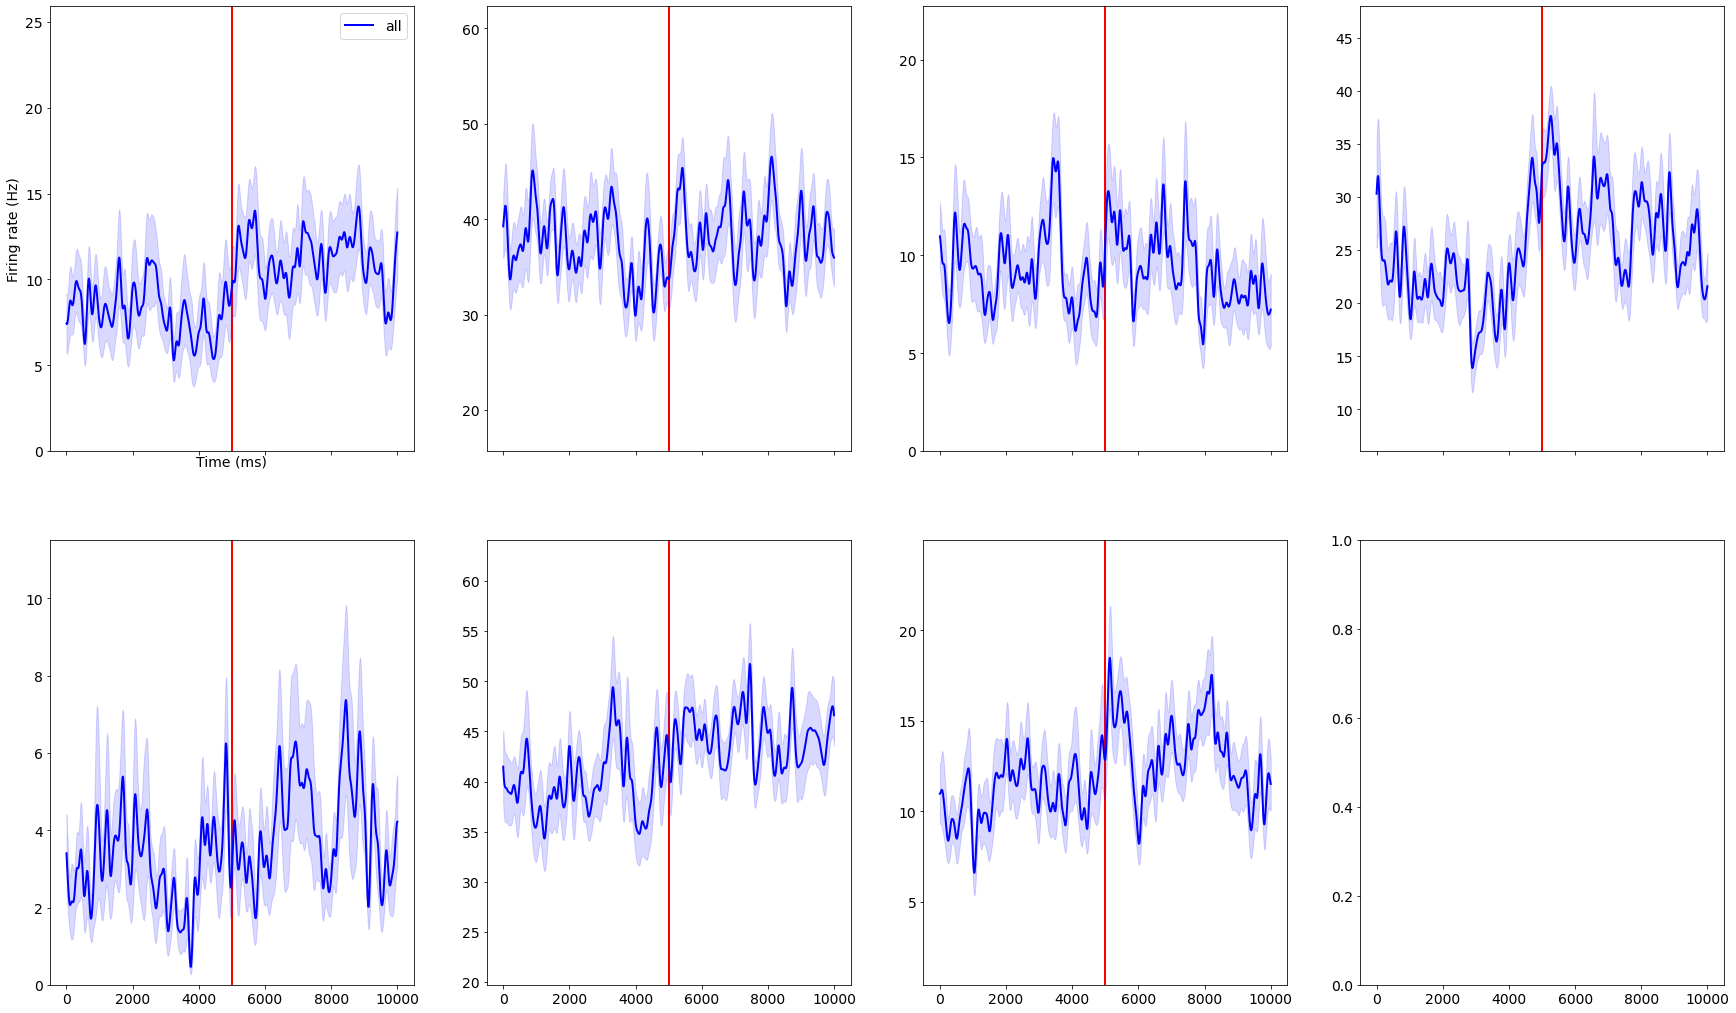

In [98]:
from fcutils.plot.figure import calc_nrows_ncols

figsize = (30, 18)
units_names = units.columns
nrows, ncols = calc_nrows_ncols(len(units_names), aspect=(24, 18))
f, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=False)
axes = axes.flatten()

DeltaT = 5000 # time before/after frame
BaselineDuration = 5000 # number of samples going into baseline evaluation

for i, (name, ax) in enumerate(zip(units_names, axes)):
    ax.axvline(DeltaT, lw=2, color="r")
    baselines = []
    alltraces = []
    for paw, timepoints, color in zip(("fr", "fl"), (right_fl_onsets, left_fl_onsets), "rg"):

        traces = []
        for frame in timepoints:
            trace = units[name].values[frame-DeltaT:frame+DeltaT]
            baseline = units[name].values[frame-BaselineDuration-1000:frame-1000]

            if len(trace) < 4000:
                continue
            traces.append(trace)
            baselines.append(baseline)
            # ax.plot(trace, color = dark_colors[paw], alpha=.25) 
            

        alltraces.extend(traces)
        # plot_mean_and_error(np.mean(traces, axis=0), sem(traces, axis=0), ax, lw=2, label=paw if i == 0 else None, color=color, err_alpha=.15)
    plot_mean_and_error(np.mean(alltraces, axis=0), sem(alltraces, axis=0), ax, lw=2, label="all" if i == 0 else None, color='blue', err_alpha=.15)
    ax.set(ylim=[np.percentile(alltraces, 10), np.percentile(alltraces, 90)])

    # baselines = np.hstack(baseline)
    # mu = np.mean(baselines)
    # sigma = np.std(baselines)
    # plot_mean_and_error(np.repeat(mu, 2*DeltaT), np.repeat(sigma, 2*DeltaT), ax, lw=2, color="black", err_alpha=.15)

axes[0].legend()
_ = axes[0].set(xlabel="Time (ms)", ylabel="Firing rate (Hz)")

## Speed tuning

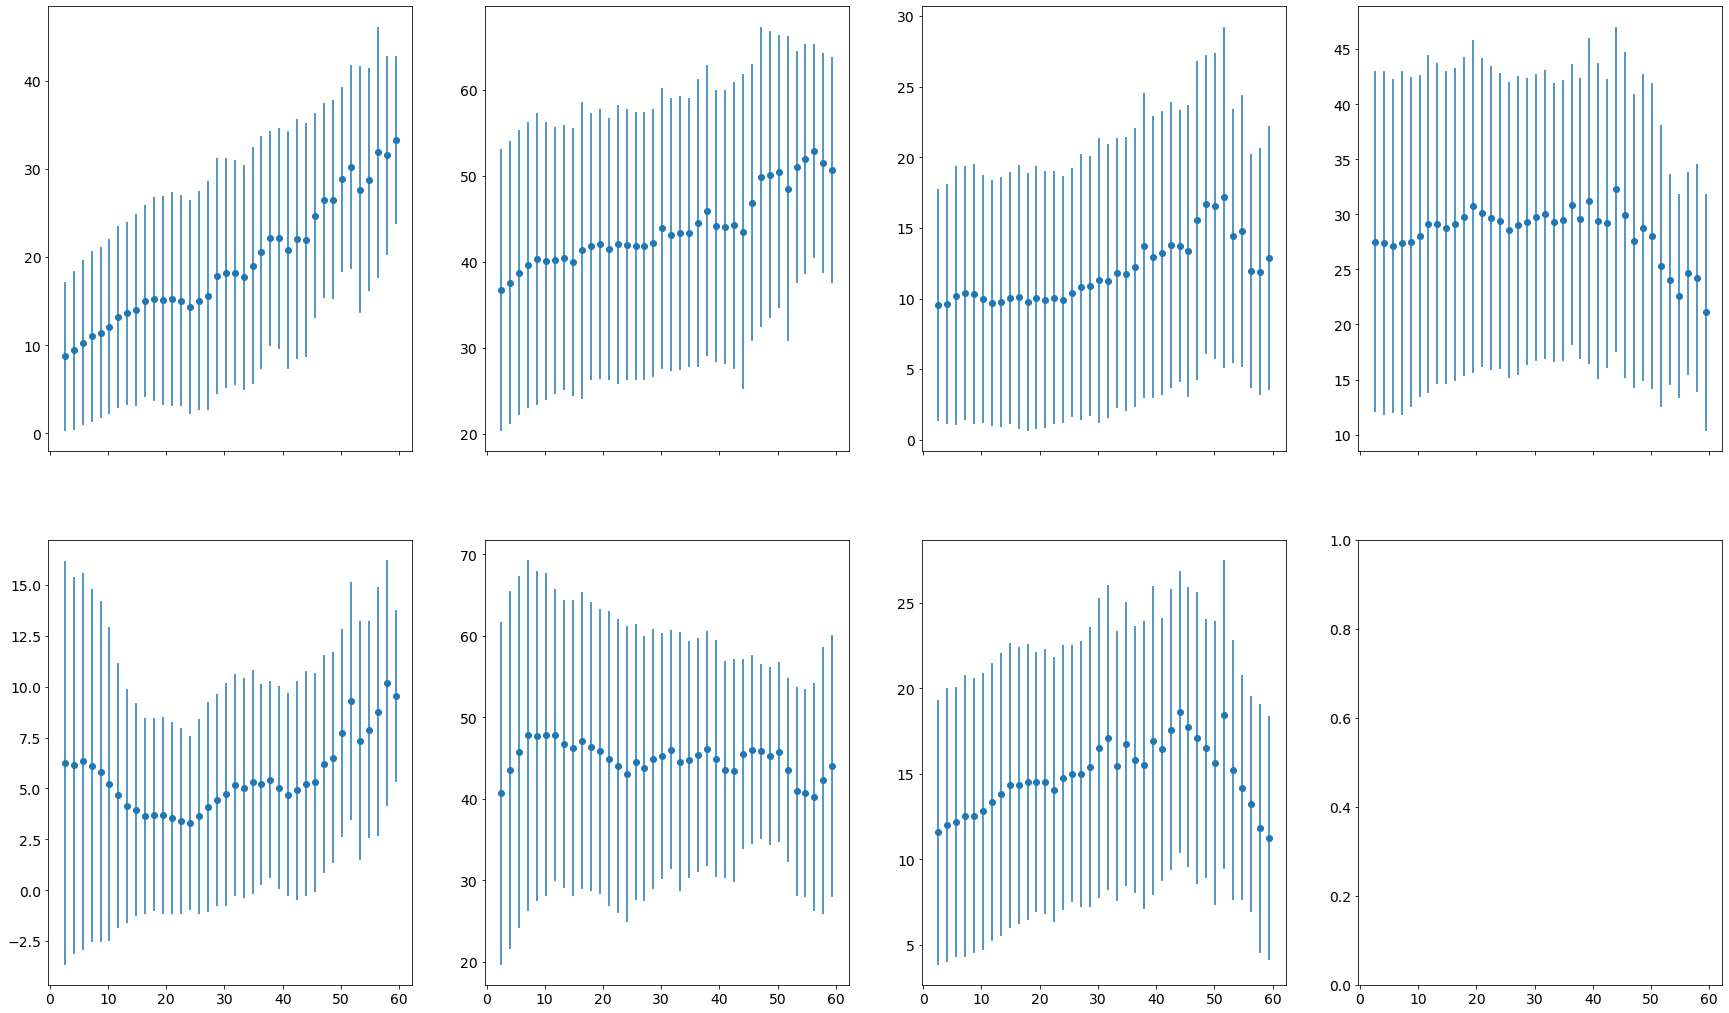

In [99]:
smoothing = 251
v = rolling_mean(tracking.v, smoothing)
counts, bin_edges = np.histogram(tracking.v, bins=50)

v = tracking.v


figsize = (30, 18)
units_names = units.columns
nrows, ncols = calc_nrows_ncols(len(units_names), aspect=(24, 18))
f, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=False)
axes = axes.flatten()


for i, (name, ax) in enumerate(zip(units_names, axes)):
    activity = rolling_mean(units[name].values, smoothing)

    x, y, sigma = [], [], []
    for n, (l, h) in enumerate(zip(bin_edges[1:], bin_edges[2:])):
        if counts[n] < 1000:
            continue
        x.append(h-l/2 + l)

        vals = activity[(v >l)&(v < h)]
        y.append(np.mean(vals))
        sigma.append(np.std(vals)
        )

    
    ax.errorbar(x, y, yerr=sigma, fmt="o")
